<a href="https://colab.research.google.com/github/wanasyraf4/CUDA-Regression/blob/main/cuBLASvsNumpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Calling CUDA from Python to Speed Up Linear Algebra**

In [3]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1553  100  1553    0     0   7502      0 --:--:-- --:--:-- --:--:--  7466
********************************************************************************
CUDA version could not be detected!
Try installing Chainer manually by: pip install chainer
********************************************************************************


In [4]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import itertools
import functools

A regressor is also known as: An independent variable

In [5]:
# Base class of regressor

class Regressor(object):

# estimate parameter given training dataset

# Parameters
# ----------
# X : (sample_size, n_features) cp.ndarray
#     training data input
# t : (sample_size,) cp.ndarray
#     training data target 

  def fit(self, X, t, **kwargs):
    self._check_input(X)
    self._check_target(t)
    if hasattr(self, "_fit"):
      self._fit(X, t, **kwargs)
    else:
      raise NotImplementedError

# Predict the output of the model

#  X : (sample_size, n_features) cp.ndarray
#             samples to predict their output
#         Returns
# -----------------------------------------------
#  y : (sample_size,) cp.ndarray
#      prediction of each sample

  def predict(self, X, **kwargs):
    self._check_input(X)
    if hasattr(self, "_predict"):
       return self._predict(X, **kwargs)
    else:
       raise NotImplementedError

  def _check_input(self, X):
      if not isinstance(X, cp.ndarray):
          raise ValueError("X(input) is not cp.ndarray")
      if X.ndim != 2:
          raise ValueError("X(input) is not two dimensional array")
      if hasattr(self, "n_features") and self.n_features != cp.size(X, 1):
          raise ValueError(
                "mismatch in dimension 1 of X(input) "
                "(size {} is different from {})"
                .format(cp.size(X, 1), self.n_features)
       )

  def _check_target(self, t):
    if not isinstance(t, cp.ndarray):
      raise ValueError("t(target) must be cp.ndarray")
    if t.ndim != 1:
      raise ValueError("t(target) must be one dimensional array")

Linear Regression

In [14]:
class LinearRegression(Regressor):
  def _fit(self, X, t):
    self.w = cp.linalg.pinv(X) @ t
    self.var = cp.mean(cp.square(X @ self.w - t))

  def _predict(self, X, return_std=False):
    y = X @ self.w
    if return_std:
      y_std = cp.sqrt(self.var) + cp.zeros_like(y)
      return y, y_std
    return y

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

cp.random.seed(1234)

In [8]:
def create_toy_data(func, sample_size, std):
    x = cp.linspace(0, 1, sample_size)
    t = func(x) + cp.random.normal(scale=std, size=x.shape)
    return x, t

def func(x):
    return cp.sin(2 * 3.14 * x)  # 3.14 should be np.pi

In [9]:
x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = cp.linspace(0, 1, 100)
y_test = func(x_test)

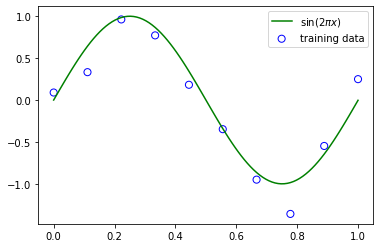

In [10]:
plt.scatter(x_train.get(), y_train.get(), facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test.get(), y_test.get(), c="g", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

In [11]:
fig1 = px.scatter(x= x_train.get(), y = y_train.get(), color=x_train.get())
fig2 = px.line (x = x_test.get(), y = y_test.get())
fig = go.Figure(data = fig1.data + fig2.data)
fig.show()

In [12]:
class PolynomialFeatures(object):

# polynomial features
# transforms input array with polynomial features
# Example
# =======
# 
#   x =  [[a, b],
#        [c, d]]
# 
#   y = PolynomialFeatures(degree=2).transform(x)
# 
#  y =   [[1, a, b, a^2, a * b, b^2],
#        [1, c, d, c^2, c * d, d^2]

  def __init__(self, degree=2):
    assert isinstance(degree, int)
    self.degree = degree

  def transform(self, x):
    if x.ndim == 1:
      x = x[:, None]
      x_t = x.transpose().get()  # https://github.com/cupy/cupy/issues/1084
      features = [np.ones(len(x))]    # https://github.com/cupy/cupy/issues/1084
      for degree in range(1, self.degree + 1):
          for items in itertools.combinations_with_replacement(x_t, degree):
              features.append(functools.reduce(lambda x, y: x * y, items))
      features = np.array(features)  # https://github.com/cupy/cupy/issues/1084
      return cp.asarray(features).transpose()


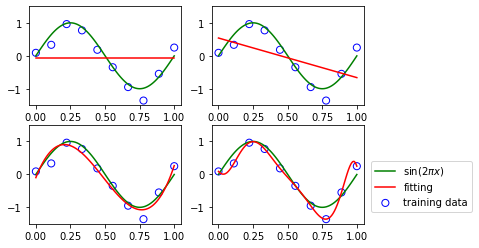

In [20]:
for i, degree in enumerate([0, 1, 3, 9]):
    plt.subplot(2, 2, i + 1)
    feature = PolynomialFeatures(degree)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y = model.predict(X_test)

    plt.scatter(x_train.get(), y_train.get(), facecolor="none", edgecolor="b", s=50, label="training data")
    plt.plot(x_test.get(), y_test.get(), c="g", label="$\sin(2\pi x)$")
    plt.plot(x_test.get(), y.get(), c="r", label="fitting")
    plt.ylim(-1.5, 1.5)
    plt.annotate("M={}".format(degree), xy=(-0.15, 1))
  
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
plt.show()